In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Any, Dict, List
from torch.utils.data import Dataset,DataLoader
from Net.dataset import NCLTDataset, nclt_collate
from Net.models import KalmanNet
from torch import Tensor
import torch
# from Net.params.make_params import get_dynamic_F
from mmengine import Config

In [2]:
dataset = NCLTDataset('./data/NCLT/processed/test.pt')
loader = DataLoader(dataset,collate_fn=nclt_collate, batch_size=128)
for batch in loader:
    break

In [3]:
len(dataset)

3

In [4]:
weight_path = 'weights/kalman560/epoch=44-val_loss=75.70-val_MSE_dB=18.79.ckpt'
# cfg_path = '/home/workspace/MOT/songj/Net/runs/new_exp_nodecay/Wheel_GPS_l100w8step2_split_Baseline_v0/configs/config.py'
cfg_path = 'weights/kalman560/config.py'

config = Config.fromfile(cfg_path)

In [5]:
from Net.utils import MODELS
model = MODELS.build(dict(type = config.trainer.type, cfg = config, save_dir = {}))


In [6]:
model

LitFusionKalmanNet(
  (model): FusionKalmanNet(
    (GRU_Q): GRU(30, 36)
    (GRU_Sigma): GRU(66, 36)
    (GRU_S): GRU(24, 4)
    (FC1): Sequential(
      (0): Linear(in_features=36, out_features=4, bias=True)
      (1): ReLU()
    )
    (FC2): Sequential(
      (0): Linear(in_features=40, out_features=1600, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1600, out_features=12, bias=True)
    )
    (FC3): Sequential(
      (0): Linear(in_features=16, out_features=36, bias=True)
      (1): ReLU()
    )
    (FC4): Sequential(
      (0): Linear(in_features=72, out_features=36, bias=True)
      (1): ReLU()
    )
    (FC5): Sequential(
      (0): Linear(in_features=6, out_features=30, bias=True)
      (1): ReLU()
    )
    (FC6): Sequential(
      (0): Linear(in_features=6, out_features=30, bias=True)
      (1): ReLU()
    )
    (FC7): Sequential(
      (0): Linear(in_features=4, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (loss_fn): MSELoss()
  (train_mse_dB): MSEd

In [7]:
from lightning import Trainer
trainer = Trainer(accelerator='gpu', devices=[0])
predictions = trainer.predict(
    model,
    loader,
    ckpt_path=weight_path
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\songj\miniconda3\envs\dr\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org

Predicting DataLoader 0: 100%|██████████| 1/1 [00:19<00:00, 19.54s/it]


In [8]:
collect = {}
for preds in predictions:
    # every batch
    batch_date: list = preds['data_date']
    for idx, date in enumerate(batch_date):
        if date not in collect :
            collect[date] = {}
            collect[date]['preds'] = [preds['preds'][idx]]
            collect[date]['targets'] = [preds['targets'][idx]]
            collect[date]['ground_truth'] = [preds['ground_truth'][idx]]
            collect[date]['gps'] = [preds['gps'][idx]]
            collect[date]['wheel'] = [preds['wheel'][idx]]
            collect[date]['mask'] = [preds['mask'][idx]]
            collect[date]['sub_id'] =  [preds['sub_id'][idx]]
        else:
            collect[date]['preds'].append(preds['preds'][idx])
            collect[date]['targets'].append(preds['targets'][idx])
            collect[date]['ground_truth'].append(preds['ground_truth'][idx])
            collect[date]['gps'].append(preds['gps'][idx])
            collect[date]['wheel'].append(preds['wheel'][idx])
            collect[date]['mask'].append(preds['mask'][idx])
            collect[date]['sub_id'].append(preds['sub_id'][idx])

In [9]:
collect.keys()

dict_keys(['2013-04-05', '2012-11-16', '2012-11-04'])

In [10]:
from Net.utils import MSE
rmse4all= MSE(squared=False)
rmse4single=MSE(squared=False)
rmse4single_gps = MSE(squared=False)
rmse4all_gps = MSE(squared=False)
times = ['2012-11-04','2012-11-16','2013-04-05']
all_rmse = []
all_gt = []
all_pred = []
gps_rmse = []
all_gps = []
for time in times:
    est = torch.hstack(collect[time]['preds'])
    mask = torch.hstack(collect[time]['mask'])
    gt = torch.hstack(collect[time]['ground_truth'])
    gps = torch.hstack(collect[time]['gps'])
    metric = torch.nn.MSELoss(reduction='mean')
    pred = est[...,mask]
    gt = gt[...,mask]
    gps = gps[...,mask]
    rmse4all.update(gt,pred)
    rmse = rmse4single(gt, pred)
    rmse4all_gps.update(gt, gps)
    all_rmse.append(rmse)
    print(f"{time} track_len= {len(gt[0,:])}, RMSE = {rmse},  gps_rmse ={rmse4single_gps(gt,gps)}")
    all_gps.append(rmse4single_gps(gt,gps))
print(f"avg rmse = {sum(all_rmse)/len(times)}")
print(f"rmse4all = {rmse4all.compute()}")
print(f"rmse4all_gps = {rmse4all_gps.compute()}")
print(f"avg_gps = {sum(all_gps)/len(times)}")

2012-11-04 track_len= 4834, RMSE = 12.456873893737793,  gps_rmse =46.1412353515625
2012-11-16 track_len= 4917, RMSE = 5.606324195861816,  gps_rmse =19.500930786132812
2013-04-05 track_len= 4182, RMSE = 5.986901760101318,  gps_rmse =34.53804397583008
avg rmse = 8.01669979095459
rmse4all = 8.69984245300293
rmse4all_gps = 35.08418655395508
avg_gps = 33.393402099609375


In [11]:
all_gps

[tensor(46.1412), tensor(19.5009), tensor(34.5380)]

In [12]:
def plot(est, gt, gt_label='gt', est_label='gps'):
    
    y1 = est[1,:]
    x1 = est[0,:]
    x2 = gt[0,:]
    y2 = gt[1, :]
    metric = torch.nn.MSELoss(reduction='mean')
    res = metric(est, gt)
    res = res.sqrt()
    plt.figure(figsize=(15,10))
    plt.plot(y1, x1, c='b', linewidth=1, label=est_label) # plot flipped since North,East
    plt.scatter(y2, x2, c='r', s=1, linewidth=1, label=gt_label)
    plt.axis('equal')
    plt.legend()
    plt.title('Comparison')
    plt.xlabel('East [m]')
    plt.ylabel('North [m]')
    print(res)

tensor(5.6063)


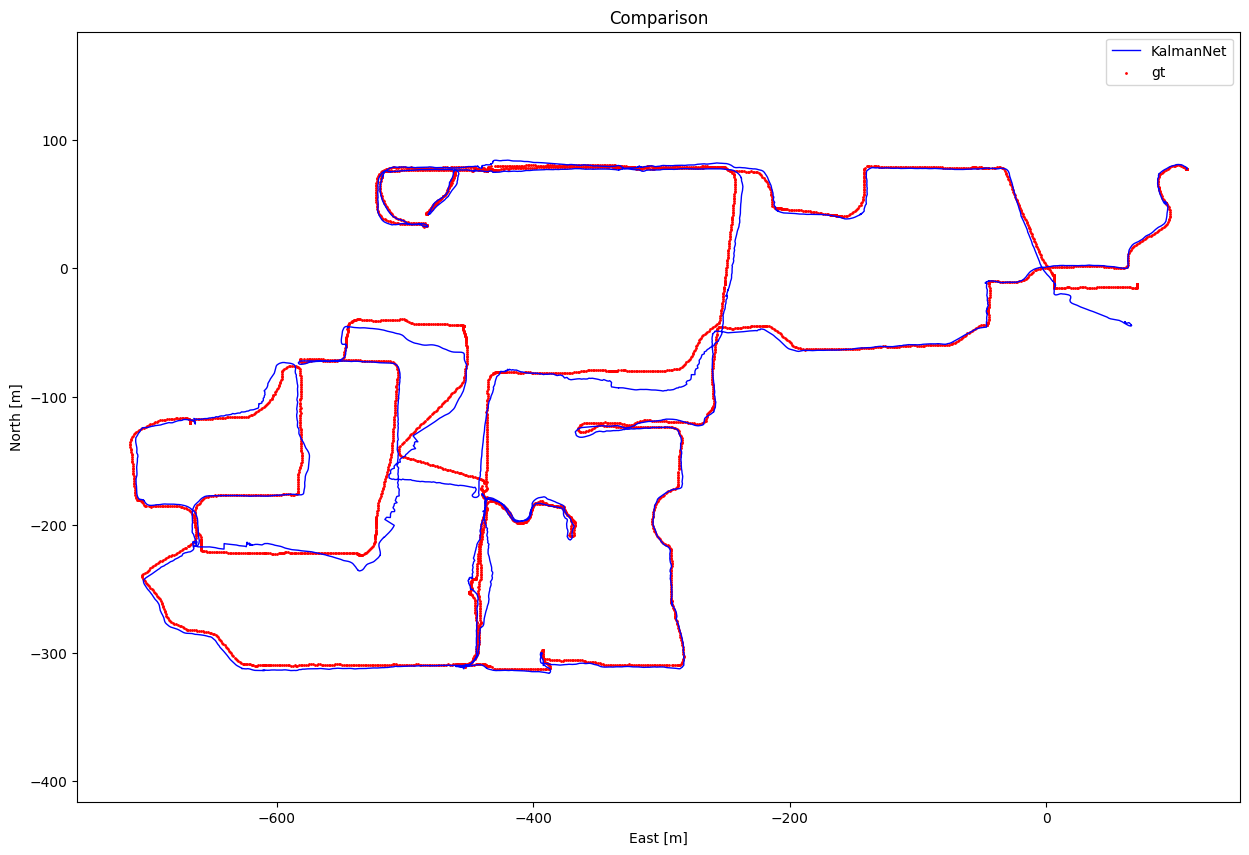

In [13]:
time = '2012-11-16'
est = torch.hstack(collect[time]['preds'])
mask = torch.hstack(collect[time]['mask'])
gt = torch.hstack(collect[time]['ground_truth'])
gps = torch.hstack(collect[time]['gps'])
plot(est[...,mask],gt[...,mask], 'gt', 'KalmanNet')

In [14]:

from lxml import etree
from data.NCLT.preprocess import _format_lat_lon, local_to_gps_coord
def export_to_kml(x1: list, y1:list, x2: list|None=None, y2:list|None=None, label1:str='test', label2:str|None=None, dataset_date:str='test', subsample=False, output_folder='output'):
    """Export list of local frame ground truth and estimated coords to KML file
    Parameters: 
    - local frame estimated coords (x,y) = (North, East) [meters]
    - local frame ground truth coords (x_gt,y_gt) = (North, East) [meters]
    Returns: KML file export
    """
    root = etree.parse('./QGIS/template.kml').getroot()
    tags = root.findall('.//name', {None : 'http://www.opengis.net/kml/2.2'}) # recurisvely find all coordinate tags in namespace
    name_tag_1 = tags[1] # 2nd name tag in kml
    name_tag_2 = tags[2] # 3rd name tag in kml
    name_tag_1.text = label1
    name_tag_2.text = label2
    tags = root.findall('.//coordinates', {None : 'http://www.opengis.net/kml/2.2'}) # recurisvely find all coordinate tags in namespace
    coord_tag_1 = tags[0]
    coord_tag_2 = tags[1]
    if x1 is not None:
        lat1,lon1 = local_to_gps_coord(x1,y1)
        formatted_coords1 = _format_lat_lon(lat1, lon1)
        coord_tag_1.text = formatted_coords1
    if x2 is not None:
        if subsample:
            # Ground truth has ~500,000 points
            x2 = x2[1::200] # sample every 200th point
            y2 = y2[1::200] # sample every 200th point
        lat2,lon2 = local_to_gps_coord(x2,y2)
        formatted_coords2 = _format_lat_lon(lat2, lon2)
        coord_tag_2.text = formatted_coords2 
    with open(f"./{output_folder}/{dataset_date}_{label1}.kml", 'wb') as f:
        f.write(etree.tostring(root, xml_declaration=True, encoding='UTF-8', pretty_print=True))

In [15]:
x1 = est[...,mask][0, :].numpy()
y1 = est[...,mask][1, :].numpy()
export_to_kml(x1,y1, label1= 'KalmanNet', dataset_date = '2012-11-16_RMSE5.60',output_folder='QGIS/20121116')